In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats
import seaborn as sbs

Import data from Costanzo et al (Science 2021).

In [139]:
datadir = "/Volumes/Storage/duality_project_data/data/"
filename ="Costanzo_et_al_Data File S1_Conditions_Strains_Fitness.xlsx"

In [140]:
df_env = pd.read_excel(datadir+filename,sheet_name=5).drop(['Systematic Name',
                                                            'Allele (Essential genes only)',
                                                            'Strain ID', 
                                                            'on Diagnostic Array'],
                                                            axis = 1)
df_env['Gene Name'] = df_env['Gene Name'].astype(str)
df_env = df_env[df_env['Gene Name']!='nan']

df_env.head()

,Gene Name,Actinomycin D,Benomyl,Boretzeomib,Caspofungin,Concanmycin A,Cycloheximide,Fluconozole,Galactose,Geldenamycin,MMS,Monensin,Rapamycin,Sorbitol,Tunicamycin
0,TFC3,0.0050,0.1380,-0.0220,-0.0180,0.0280,-0.0080,0.0510,0.0400,-0.0250,0.0290,-0.0370,-0.0020,-0.0370,-0.0240
1,VPS8,-0.4890,-0.1980,-0.1150,-0.0360,-0.1320,-0.0450,-0.0270,-0.0940,-0.0670,-0.0520,-0.0330,-0.2965,-0.1115,-0.0850
3,SSA1,-0.0310,0.0100,-0.0150,0.0260,-0.0460,-0.0020,0.0750,-0.0250,-0.0040,-0.0130,-0.0230,0.2015,0.1265,0.0430
4,ERP2,-0.0315,0.0295,0.0215,-0.0505,0.0585,0.0205,0.0215,0.0145,0.0335,-0.0435,-0.0085,0.0835,-0.0265,-0.0105
5,FUN14,0.0195,-0.0135,-0.0275,0.0315,0.0315,0.0335,-0.0515,0.0255,0.0555,0.0005,0.0225,0.0410,-0.0280,-0.0225


In [157]:
df_env[df_env['Gene Name'] == 'HSP82']

,Gene Name,Actinomycin D,Benomyl,Boretzeomib,Caspofungin,Concanmycin A,Cycloheximide,Fluconozole,Galactose,Geldenamycin,MMS,Monensin,Rapamycin,Sorbitol,Tunicamycin
4235,HSP82,-0.1575,-0.0815,-0.0055,-0.0725,-0.0015,0.0225,0.0245,0.0885,-0.1105,0.0375,0.0185,0.0025,0.0375,-0.0145


'Actinomycin D'

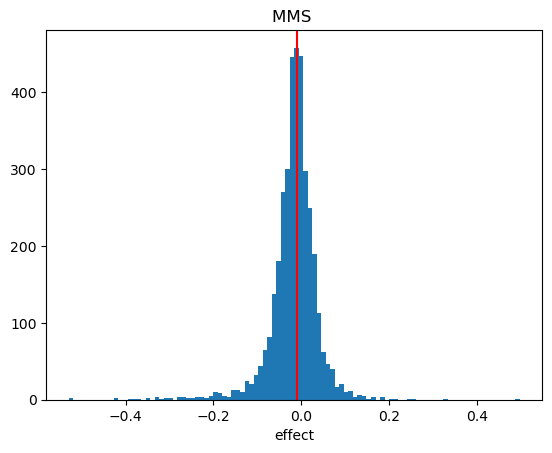

In [49]:
condition = df_env.columns[3:][7]
plt.hist(df_env[condition],bins=100)
plt.axvline(np.array(df_env[condition][df_env['Gene Name'] == 'HSC82'])[0],color = 'red')
plt.title(condition)
plt.xlabel('effect')
plt.show()

In [51]:
env_mat = np.array(df_env.drop('Gene Name',axis=1))
mask = np.sum(np.isnan(env_mat),axis=1)==0
env_mat = env_mat[mask,:]
env_mat = env_mat - np.mean(env_mat,axis = 0)
env_mat.shape
d = {'Gene Name':df_env['Gene Name'][mask],"Mean Env Effect": np.mean(env_mat,axis = 1)}
df_env_rob = pd.DataFrame(data = d)
df_env_rob.head()

,Gene Name,Mean Env Effect
0,TFC3,0.023532
1,VPS8,-0.112111
3,SSA1,0.038175
4,ERP2,0.023104
5,FUN14,0.023532


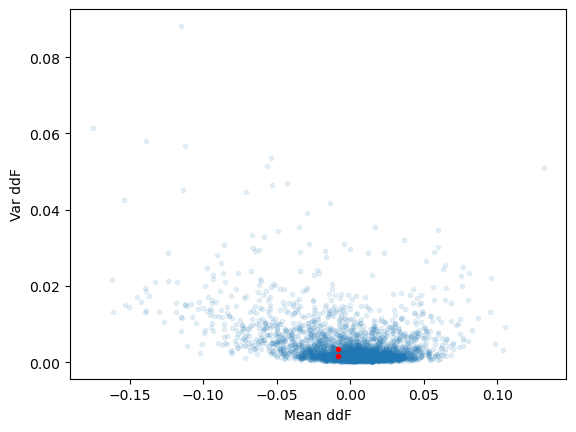

In [60]:
mean_ddF = np.mean(env_mat,axis = 1)
var_ddF = np.var(env_mat,axis = 1)
plt.scatter(mean_ddF,var_ddF,marker = '.', alpha = 0.1)
plt.scatter(mean_ddF[df_env_rob['Gene Name'] == 'HSC82'],var_ddF[df_env_rob['Gene Name'] == 'HSC82'],marker = '.', alpha = 1,color = 'red')
plt.scatter(mean_ddF[df_env_rob['Gene Name'] == 'HSC82'],var_ddF[df_env_rob['Gene Name'] == 'HSP82'],marker = '.', alpha = 1,color = 'red')

plt.ylabel('Var ddF')
plt.xlabel('Mean ddF')
plt.show()

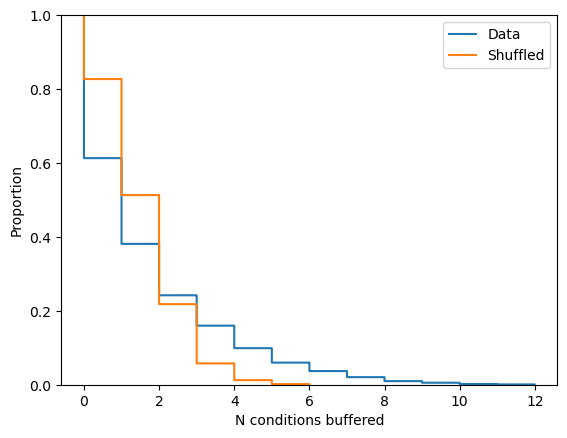

In [168]:
env_mat = np.array(df_env.drop('Gene Name',axis=1))
binarized = env_mat <-.08
sbs.ecdfplot(x=np.sum(binarized,axis =1 ),complementary=True,label="Data" )
idx = np.random.rand(*binarized.shape).argsort(0)
to_shuffle = binarized[idx, np.arange(binarized.shape[1])]
sbs.ecdfplot(x=np.sum(to_shuffle,axis = 1),complementary=True, label = 'Shuffled' )
plt.ylim((0,1))
plt.xlabel("N conditions buffered")
plt.legend()
plt.show()

In [144]:
df_binarized_env = pd.DataFrame(data = {'Gene Name' : df_env['Gene Name'],'Neg Env':np.sum(binarized,axis =1 ) })
df_binarized_env.head()

,Gene Name,Neg Env
0,TFC3,0
1,VPS8,8
3,SSA1,0
4,ERP2,0
5,FUN14,0


In [70]:
env_mat.shape

(3630, 14)

In [106]:
filename = 'SGA_NxN.txt'
df_mut = pd.read_csv(datadir+filename,sep='\t').drop(['Query Strain ID',
                                                      'Array Strain ID',
                                                      'Arraytype/Temp', 
                                                      'Array SMF',
                                                      'Query single mutant fitness (SMF)',
                                                      'Double mutant fitness', 
                                                      'Double mutant fitness standard deviation'],
                                                    axis = 1)
for col in np.array(['Array allele name','Query allele name']):
    df_mut[col] = df_mut[col].astype(str)
    df_mut = df_mut[df_mut[col]!='nan']
#df_mut = df_mut.rename(columns={"Query single mutant fitness (SMF)": "Query SMF"})

df_mut.head()

,Query allele name,Array allele name,Genetic interaction score (ε),P-value
0,vps8,ecm15,0.1226,0.002185
1,vps8,hta2,0.0269,0.242000
2,vps8,pdr3,-0.0228,0.297900
3,vps8,sla1,-0.0535,0.166300
4,vps8,hir1,0.0532,0.071490


In [107]:
df_mut_int = df_mut.pivot(index = "Query allele name", columns = "Array allele name", values = "Genetic interaction score (ε)")
df_mut_p = df_mut.pivot(index = "Query allele name", columns = "Array allele name", values = "P-value")
df_mut_int.head()

Array allele name,YAL043C-A_dma42,YAL058C-A_dma57,YDL134C-A_dma711,YFL035C-B_dma1491,YHR079C-B_dma2128,YIL015C-A_dma2248,YIR020W-B_dma2436,YJL206C-A_dma2602,YML010C-B_dma3525,YML035C-A_dma3550,...,zds2,zeo1,zip1,zip2,znf1,zrc1,zrg17,zrt2,zrt3,zta1
Query allele name,,,,,,,,,,,,,,,,,,,,,
HSC82_sn2174_T30,0.0172,0.0308,-0.0262,-0.0237,0.0146,-0.0123,-0.0097,0.0265,NaN,NaN,...,NaN,-0.0031,0.0079,-0.0401,0.0051,NaN,-0.0472,-0.0023,0.0302,-0.0104
aac1,0.0150,-0.0081,-0.0093,-0.0241,-0.0453,-0.0249,0.0126,-0.0019,NaN,NaN,...,NaN,-0.0325,0.0188,0.0070,-0.0159,NaN,-0.0014,-0.0237,0.0634,-0.0169
aac3,NaN,-0.0114,NaN,0.0349,-0.0287,-0.0450,0.1029,-0.0215,0.0293,-0.1455,...,0.0214,0.0377,0.0357,0.0608,0.0671,-0.1022,0.0635,0.0520,-0.0763,NaN
aad10,0.0373,-0.0047,0.0202,0.0551,0.0260,-0.0384,NaN,-0.0412,-0.0074,0.0415,...,-0.0017,-0.0327,0.0496,0.0407,-0.0035,-0.0440,-0.0325,-0.0139,NaN,0.0397
aad15,-0.0939,-0.0169,0.0283,0.0250,-0.0236,-0.0080,-0.0209,0.0376,0.0749,0.0378,...,-0.0176,-0.1147,0.0249,-0.0116,-0.0031,0.0397,-0.0863,-0.0177,-0.0448,-0.0653


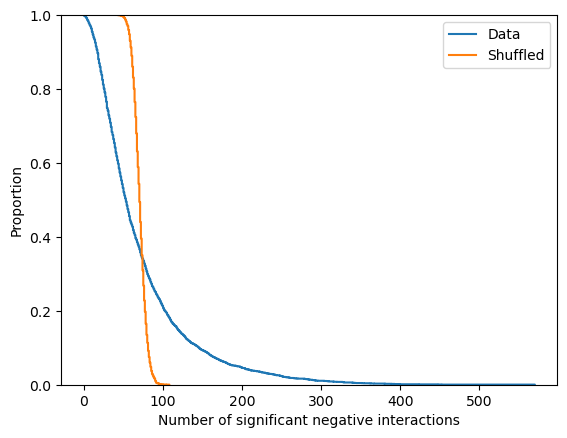

In [137]:
binarized_int = (np.array(df_mut_int) < -0.08) & (np.array(df_mut_p) < 0.05)
sbs.ecdfplot(x=np.sum(binarized_int,axis = 1),complementary=True ,label = 'Data')
idx = np.random.rand(*binarized_int.shape).argsort(0)
to_shuffle = binarized_int[idx, np.arange(binarized_int.shape[1])]
sbs.ecdfplot(x=np.sum(to_shuffle,axis = 1),complementary=True, label = 'Shuffled' )
plt.xlabel('Number of significant negative interactions')
plt.legend()
plt.show()

In [146]:
df_binarized_mut = pd.DataFrame(data = {'Gene Name' : df_mut_int.index,'Neg Mut':np.sum(binarized_int,axis = 1) })
df_binarized_mut.head()

,Gene Name,Neg Mut
0,HSC82_sn2174_T30,94
1,aac1,14
2,aac3,229
3,aad10,35
4,aad15,44


In [148]:
df_binarized_mut['Gene Name'] = df_binarized_mut['Gene Name'].apply(str.upper)
df_binarized_env['Gene Name'] = df_binarized_env['Gene Name'].apply(str.upper)
df_binarized = pd.merge(df_binarized_mut,df_binarized_env,how = "inner",on="Gene Name")
df_binarized.head()

,Gene Name,Neg Mut,Neg Env
0,AAC1,14,0
1,AAC3,229,1
2,AAD4,91,0
3,AAP1,12,1
4,AAT1,105,0


In [156]:
df_binarized[df_binarized['Gene Name'] == "HSP82"]

,Gene Name,Neg Mut,Neg Env
816,HSP82,2,3


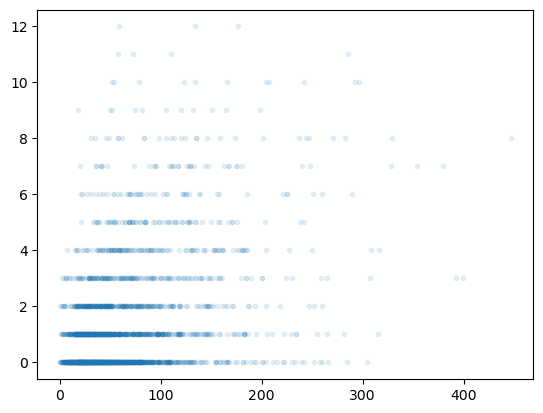

In [151]:
plt.scatter(df_binarized['Neg Mut'],df_binarized['Neg Env'],marker = ".",alpha = 0.1)


In [159]:
np.unique(df_binarized['Neg Env'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

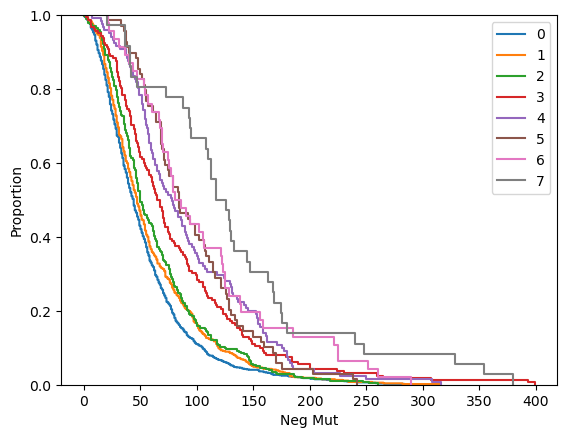

In [173]:
for i in range(0,8):
    sbs.ecdfplot(x=df_binarized['Neg Mut'][df_binarized['Neg Env'] == i],complementary=True ,label = i)
plt.legend()

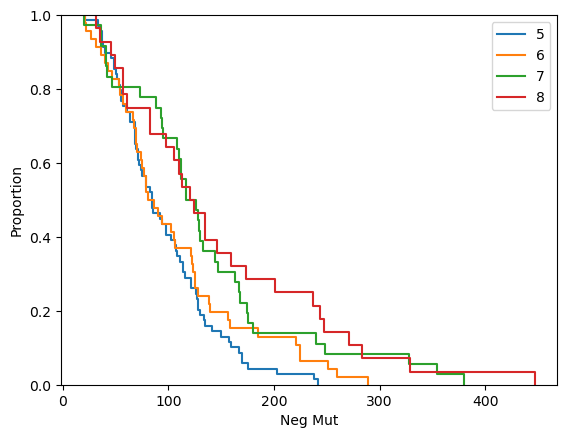

In [167]:
for i in range(5,9):
    sbs.ecdfplot(x=df_binarized['Neg Mut'][df_binarized['Neg Env'] == i],complementary=True ,label = i)
plt.legend()

In [158]:
scipy.stats.spearmanr(df_binarized['Neg Mut'],df_binarized['Neg Env'])

SpearmanrResult(correlation=0.3008220416909296, pvalue=2.775092010826683e-48)

In [76]:
df_mut['ddF'] = (df_mut['Double mutant fitness']-1)\
              - (df_mut['Array SMF']-1)\
              - (df_mut['Query SMF']-1)
df_mut.head()

,Query allele name,Array allele name,Query SMF,Array SMF,Double mutant fitness,ddF
0,vps8,ecm15,0.7552,1.0112,0.8862,0.1198
1,vps8,hta2,0.7552,1.0005,0.7825,0.0268
2,vps8,pdr3,0.7552,1.0248,0.7512,-0.0288
3,vps8,sla1,0.7552,0.8230,0.5681,-0.0101
4,vps8,hir1,0.7552,0.9370,0.7608,0.0686


In [95]:
df_mut_pair = df_mut[['Query allele name','Array allele name','ddF']]
#df_mat = df_mut_pair.pivot(columns = "Query allele name",values = 'ddF')
df_mut_pair.head()

,Query allele name,Array allele name,ddF
0,vps8,ecm15,0.1198
1,vps8,hta2,0.0268
2,vps8,pdr3,-0.0288
3,vps8,sla1,-0.0101
4,vps8,hir1,0.0686


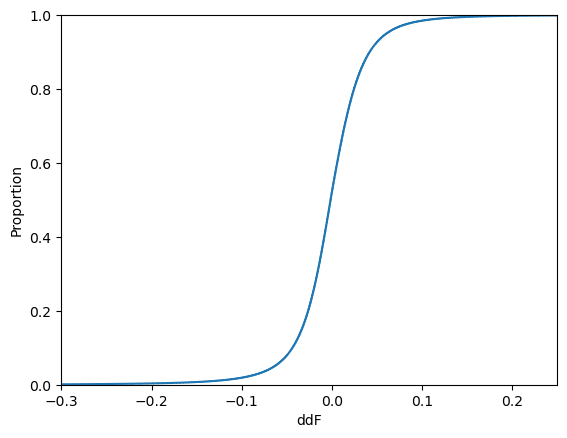

In [81]:

sbs.ecdfplot(data = df_mut_pair, x='ddF')
plt.xlim((-.3,.25))
plt.show()

In [96]:
np.sum(df_mut_pair['ddF']<-.11)/len(df_mut_pair['ddF'])
df_mut_pair['binarized'] =  np.array(df_mut_pair['ddF']<-.11)

/var/folders/yg/rz5s_kp914g5hjl723fncj_80000gn/T/ipykernel_21142/1785492307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mut_pair['binarized'] =  np.array(df_mut_pair['ddF']<-.11)


0.014574939860921409

In [92]:
len(df_mut_pair['ddF'])

11295484

In [17]:
gene_list = np.unique(np.array(df_mut_pair['Query allele name']))
mean_ddF = np.zeros(len(gene_list))
for i in tqdm(range(len(gene_list))):
    mean_ddF[i] =np.mean(df_mut_pair['ddF'][df_mut_pair['Query allele name'] == gene_list[i]])

100%|███████████████████████████████████████| 3283/3283 [28:12<00:00,  1.94it/s]


In [100]:
gene_list = np.unique(np.array(df_mut_pair['Query allele name']))
binarized_ddF = np.zeros(len(gene_list))
for i in tqdm(range(len(gene_list))):
    binarized_ddF[i] =np.sum(df_mut_pair['binarized'][df_mut_pair['Query allele name'] == gene_list[i]])

 94%|████████████████████████████████████▌  | 3073/3283 [26:54<01:50,  1.90it/s]


KeyboardInterrupt: 

In [24]:
df_mut_rob = pd.DataFrame(data = {'Gene Name': gene_list,'mean mut ddF':mean_ddF})
df_mut_rob = df_mut_rob[~np.isnan(df_mut_rob['mean mut ddF'])]
df_mut_rob.head()

,Gene Name,mean mut ddF
1,aac1,-0.003681
2,aac3,-0.011043
3,aad10,-0.003076
4,aad15,-0.002397
5,aad16,-0.001142


In [30]:
df_mut_rob['Gene Name'] = df_mut_rob['Gene Name'].apply(str.upper)
df_env_rob['Gene Name'] = df_env_rob['Gene Name'].apply(str.upper)
df_joint = pd.merge(df_mut_rob,df_env_rob,how='inner',on='Gene Name')

df_joint.head()

,Gene Name,mean mut ddF,Mean Env Effect
0,AAC1,-0.003681,0.022818
1,AAC3,-0.011043,-0.003468
2,AAD4,-0.003052,-0.003682
3,AAP1,-0.005523,0.020175
4,AAT1,-0.002229,0.007604


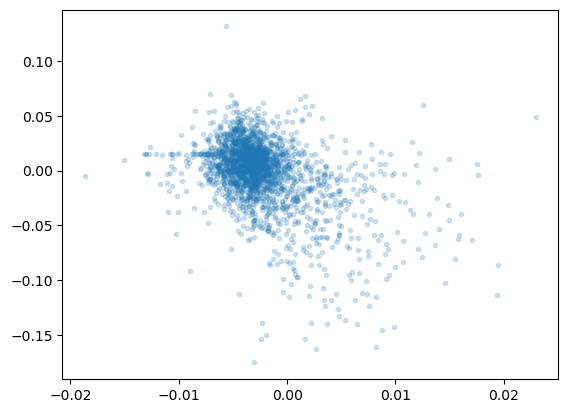

In [33]:
plt.scatter(df_joint['mean mut ddF'],df_joint['Mean Env Effect'],marker='.',alpha = 0.2)

In [35]:
mut = np.array(df_joint['mean mut ddF'])
env = np.array(df_joint['Mean Env Effect'])
scipy.stats.spearmanr(mut,env)

SpearmanrResult(correlation=-0.3588812259424312, pvalue=1.9758592528260034e-68)

In [172]:
datadir = "/Volumes/Storage/duality_project_data/data/"
filename = 'Costanzo et al_Data File S3_Raw interaction dataset.xlsx'
df_double = pd.read_excel(datadir+filename,sheet_name=1)
df_double.head()

,query_orf,array_orf,Condition,query_common,array_common,rep1_condition_epsilon,rep2_condition_epsilon,mean_condition_epsilon,sd_condition_epsilon,condition_p_value,...,rep1_differential_epsilon,rep2_differential_epsilon,mean_differential_epsilon,sd_differential_epsilon,differential_p_value,Differential Interaction Sign,Differential interaction class,Query-Array,epsilon_Costanzo et al 2016,pvalue_Costanzo et al 2016
0,YBR254C_tsq1398,YNL141W_dma4038,Benomyl,TRS20,AAH1,0.008105,-0.111949,-0.051922,0.042741,0.224437,...,0.161988,0.055347,0.108667,0.054712,0.047014,Positive,Masked Negative GI,TRS20_AAH1,-0.087821,0.046210
1,YIR010W_tsq435,YFL039C_tsa911,Benomyl,DSN1,ACT1,0.017097,0.002072,0.009585,0.022799,0.674191,...,0.089108,0.122706,0.105907,0.027360,0.000108,Positive,Masked Negative GI,DSN1_ACT1,0.003932,0.493500
2,YMR299C_sn1495,YFL039C_tsa911,Benomyl,DYN3,ACT1,-0.013749,-0.025051,-0.019400,0.017198,0.259291,...,0.073061,0.106386,0.089723,0.036495,0.013950,Positive,Masked Negative GI,DYN3_ACT1,-0.188916,0.002846
3,YNL153C_sn1660,YFL039C_tsa910,Benomyl,GIM3,ACT1,-0.001443,-0.015586,-0.008514,0.012912,0.509623,...,0.056184,0.132421,0.094303,0.039323,0.016478,Positive,Masked Negative GI,GIM3_ACT1,-0.141141,0.027300
4,YNL153C_sn1660,YFL039C_tsa220,Benomyl,GIM3,ACT1,0.036237,0.003141,0.019689,0.021494,0.359647,...,0.075292,0.196090,0.135691,0.060511,0.024933,Positive,Masked Negative GI,GIM3_ACT1,-0.241100,0.000627
